## Data Intake + Prep

Cleaning is one of the most important aspects of any project. Below I attempt to:

1. Pull in data via API, create datasets
2. Find missing or bad data, these rows could skew our analysis, especially if features contain many missing values or behave in unexpected ways.
3. Apply cleaning rules to data.
4. Merged datasets to have a beginning endline dataset to run EDA over.

---

Weekend:

- Add Clean
- Add Merge
- Add Some Dropping


In [190]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import matplotlib.pyplot as plt
from itertools import chain
import os
import re
import string
from thefuzz import fuzz, process


try:
    os.chdir("./Animal_Adoption_ML_Python/")
except FileNotFoundError:
    pass


In [191]:
from wordcloud import WordCloud  # pip install wordcloud


In [192]:
# Define way to create raw data from API
def data_feeder(df):
    a = pd.DataFrame.from_records(df)
    a.columns = a.iloc[0]
    a = a[1:]
    # Annoying feature of from_records is that it replaces NaN with ''
    a = a.replace("", np.nan)
    return a


In [193]:
# Call API to get Data
client = Socrata("data.austintexas.gov", "HwnJIRk3Ph7NqQ0cPB0MOPkTF")
intake = client.get("wter-evkm", limit=99999999, content_type="csv")
outcome = client.get("9t4d-g238", limit=99999999, content_type="csv")

# Make data
intake_df = data_feeder(intake)
outcome_df = data_feeder(outcome)
geocoded_df = pd.read_csv("geocoded_locations.csv")


In [194]:
print("Intake Dataset")
intake_df.head(5)


Intake Dataset


,animal_id,name,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color
1,A665644,NaN,2013-10-21T07:59:00.000,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
2,A665739,*Alana,2013-10-22T11:11:00.000,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black
3,A665763,NaN,2013-10-22T15:10:00.000,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White
4,A379998,Disciple,2013-10-23T11:42:00.000,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,Dog,Intact Male,10 years,Pit Bull,Black
5,A634503,Otter,2013-10-01T14:49:00.000,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan


In [195]:
print("Outcome Dataset")
outcome_df.head(5)


Outcome Dataset


,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,outcome_subtype,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
1,A794011,Chunk,2019-05-08T18:20:00.000,2019-05-08T18:20:00.000,2017-05-02T00:00:00.000,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
2,A776359,Gizmo,2018-07-18T16:02:00.000,2018-07-18T16:02:00.000,2017-07-12T00:00:00.000,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
3,A821648,NaN,2020-08-16T11:38:00.000,2020-08-16T11:38:00.000,2019-08-16T00:00:00.000,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
4,A720371,Moose,2016-02-13T17:59:00.000,2016-02-13T17:59:00.000,2015-10-08T00:00:00.000,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
5,A674754,NaN,2014-03-18T11:47:00.000,2014-03-18T11:47:00.000,2014-03-12T00:00:00.000,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


### 2. Clean + Merge data

Next I can do some light cleaning to make the the initial EDA easier. After I can merge intake with outcome to understand any odd looking data.


In [196]:
# Clean Data
def lower_case_col(columns):
    return columns.replace(" ", "_").lower()


In [197]:
# Clean up by...
def clean_up(dataframe, name):
    return (
        dataframe
        # fix columns
        .rename(columns=lower_case_col)
        # Indicate if animal had name
        .assign(
            name_avail=np.where(dataframe.name.isna(), 0, 1),
            datetime=pd.to_datetime(dataframe.datetime),
            # extract month out of our date
            month=lambda x: x.datetime.dt.month,
            # merge
            merge_counter=lambda x: x.sort_values(by="datetime")
            .groupby(["animal_id"])
            .cumcount()
            + 1,
        )
        .rename(columns={"datetime": name + "_datetime", "month": name + "_month"})
        .drop(["name"], axis=1)
    )


# Apply to Data
intake_df_clean = clean_up(intake_df, "intake")
outcome_df_clean = clean_up(outcome_df, "outcome")


In [198]:
## Now merge
merged_df = intake_df_clean.merge(
    outcome_df_clean[
        [
            "outcome_type",
            "animal_id",
            "outcome_datetime",
            "outcome_month",
            "merge_counter",
        ]
    ],
    on=["animal_id", "merge_counter"],
    how="outer",
    indicator=True,
)

# Okay most merged!
print("All Merges")
print(merged_df._merge.value_counts())

# Lets ensure we didn't make any mistakes
print("\nAnimals whose IDs were both merged and not-merged")
print(
    merged_df.loc[
        merged_df.animal_id.isin(
            merged_df.loc[merged_df._merge != "both", "animal_id"]
        ),
        "_merge",
    ].value_counts()
)

# Out of an abundance of caution I will drop any animal who somehow both merged and didn't merge (fear is that I messed up on date on intake and outcome so that every subsequent merge for this animal is screwed up too)
merged_df = merged_df.loc[
    ~merged_df.animal_id.isin(merged_df.loc[merged_df._merge != "both", "animal_id"])
]


merged_df.head(2)


All Merges
both          148822
right_only       925
left_only        793
Name: _merge, dtype: int64

Animals whose IDs were both merged and not-merged
right_only    925
left_only     793
both          302
Name: _merge, dtype: int64


,animal_id,intake_datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name_avail,intake_month,merge_counter,outcome_type,outcome_datetime,outcome_month,_merge
0,A665644,2013-10-21 07:59:00,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,0.0,10.0,1,Transfer,2013-10-21 11:39:00,10.0,both
1,A665739,2013-10-22 11:11:00,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black,1.0,10.0,1,Adoption,2013-12-20 17:36:00,12.0,both


### 3. Find bad/missing data:

Here I am looking for any columns that might be problematic to our analysis (many missing values, extreme values, or nonsensical values that require more digging).

I want to automate this, if we find a small amount of NaN's we should be fine to just drop/replace them. If these NaN become a larger issues (lets say > %2) we need to pause and manually inspect what is going on.

It should be noted that this notebook is a little backwards, I was able to do a mix of EDA and bad data cleanup in unison but for clarity to an external audience I just separate the two. This means I found odd relationships later into EDA but came back up here to insert cleaning rules.


In [199]:
# Let's make a function to output what's missing
def percent_missing(df):
    percent_nan = 100 * df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan > 0].sort_values()
    drop_list = percent_nan[(percent_nan < 2) & percent_nan != 0]
    if percent_nan.shape[0] == 0:
        print("No NA values, consider checking the data")
    else:
        print("Rows with NAs")
        print(percent_nan)
    return drop_list.index.to_list()


percent_missing(merged_df)


Rows with NAs
0
outcome_type    0.016833
dtype: float64


['outcome_type']

Weird rows with datetime (None):


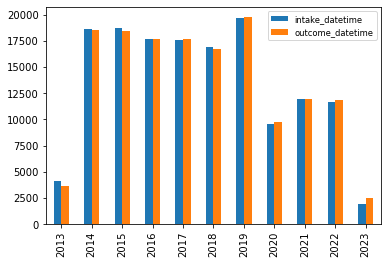

In [200]:
# Check all columns and see if odd values appear frequently

# For datetime it would be an impossibly early date or dates where outcome > intake
print("Weird rows with datetime (None):")
merged_df[["intake_datetime", "outcome_datetime"]].apply(lambda x: x.dt.year).apply(
    lambda x: x.value_counts()
).plot(kind="bar")
plt.legend(fontsize="small")


In [201]:
# Check negative adoption length

# what I found is that some outcomes are recorded on a day only basis, so if an animal was adopted within a day it will be negative, for example:
# intake was Jan 1 at 2pm, outtake was Jan 1 at 4pm. Rescue will not code 4pm, so it looks like the animal was adopted at 12:00AM on Jan 1 instead.
# Therefore the difference needs to be longer than a full day.

merged_df = merged_df.assign(
    differ=lambda x: x.outcome_datetime - x.intake_datetime,
    is_neg=lambda x: x.differ.apply(
        lambda x: 1 if x.total_seconds() < -(60 * 60 * 24) else 0
    ),
)

print("Adoption length is less than 0 days:")
print(merged_df.is_neg.value_counts())

# Drop all IDs that had negative time
merged_df = merged_df.loc[
    ~merged_df.animal_id.isin(merged_df.loc[merged_df.is_neg == 1, "animal_id"])
]


Adoption length is less than 0 days:
0    148515
1         5
Name: is_neg, dtype: int64


In [202]:
# For categoricals we can just check out the strings to see if weird values populate
cats = [
    "intake_type",
    "intake_condition",
    "animal_type",
    "sex_upon_intake",
    "intake_month",
    "outcome_type",
]
for i in cats:
    values = merged_df[i].value_counts()
    print(i, ": \n", values, "\n")


intake_type : 
 Stray                 101776
Owner Surrender        30770
Public Assist           8917
Wildlife                5754
Abandoned               1034
Euthanasia Request       258
Name: intake_type, dtype: int64 

intake_condition : 
 Normal        127420
Injured         8631
Sick            6479
Nursing         3929
Neonatal         680
Aged             478
Other            319
Medical          236
Feral            133
Pregnant         115
Behavior          61
Med Urgent         7
Med Attn           6
Unknown            4
Space              4
Neurologic         3
Agonal             2
Panleuk            1
Parvo              1
Name: intake_condition, dtype: int64 

animal_type : 
 Dog          83174
Cat          56636
Other         7919
Bird           754
Livestock       26
Name: animal_type, dtype: int64 

sex_upon_intake : 
 Intact Male      49484
Intact Female    47238
Neutered Male    21662
Spayed Female    18404
Unknown          11719
NULL                 2
Name: sex_upon

In [203]:
# Lets check alter these intake_conditions as theres some overlap with sparse classes, for instance panleuk is just sick, nursing and pregnant are close enough:
clean_intake = {
    "normal": ["Normal"],
    "injured_or_sick": [
        "Injured",
        "Medical",
        "Sick",
        "Medical",
        "Med Urgent",
        "Med Attn",
        "Neurologic",
        "Agonal",
        "Panleuk",
    ],
    "nursing_or_mom": ["Nursing", "Pregnant"],
    "neonatal": ["Neonatal"],
    "old": ["Aged"],
    "feral": ["Feral"],
    "behavior": ["Behavior"],
}

# all other labels is in the other category
other_values = chain(*list(clean_intake.values()))
clean_intake["other"] = (
    merged_df[~merged_df.intake_condition.isin(other_values)]["intake_condition"]
    .unique()
    .tolist()
)

# transform
merged_df["intake_condition"] = merged_df.intake_condition.replace(
    {val: key for key, vals in clean_intake.items() for val in vals}
)


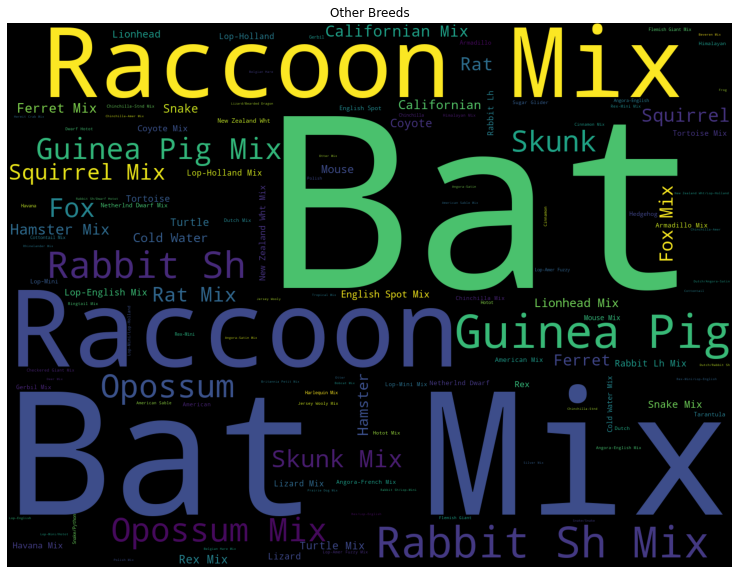

In [204]:
# Lets check out what 'other' means for animal type... Looks like wildlife, but some rabbits, ferrets, etc... I think I will lop farm animals into this?
cat_mix_text = (
    intake_df.loc[intake_df.animal_type == "Other", "breed"].value_counts().to_dict()
)
cloud = WordCloud(width=1440, height=1080).generate_from_frequencies(cat_mix_text)
plt.figure(figsize=(15, 10))
plt.title("Other Breeds")
plt.imshow(cloud)
plt.axis("off")

merged_df["animal_type"] = merged_df.animal_type.apply(
    lambda x: "Other" if x == "Livestock" else x
)


In [205]:
# Check out the Unknowns in sex, its just wild animals mostly. While Some cats or dogs, proportionally its miniscule. Do nothing but drop NULL
print("Unknown is mostly Other animals (normalize but rows and columns):")
print(
    pd.crosstab(merged_df.sex_upon_intake, merged_df.animal_type, normalize="all") * 100
)

merged_df = merged_df.loc[merged_df.sex_upon_intake != "NULL"]


Unknown is mostly Other animals (normalize but rows and columns):
animal_type          Bird        Cat        Dog     Other
sex_upon_intake                                          
Intact Female    0.082150  14.247621  17.067652  0.410750
Intact Male      0.142079  13.488745  19.205570  0.484146
NULL             0.000000   0.000000   0.001347  0.000000
Neutered Male    0.000000   3.900774  10.633026  0.052522
Spayed Female    0.000000   3.650957   8.701830  0.039728
Unknown          0.283485   2.848312   0.396609  4.362699


In [206]:
# Lastly check out outcome type:
print("Unique Values of outcomes:\n", merged_df.outcome_type.value_counts())

# Just combine a few:
outcome_dict = {
    "adopt": ["Adoption", "Return to Owner", "Rto-Adopt"],
    "deceased": ["Euthanasia", "Disposal", "Died"],
    "transfer_other_org": ["Transfer", "Relocate"],
}

# all other labels will be dropped.
other_values = chain(*list(outcome_dict.values()))
outcome_dict["other"] = (
    merged_df[~merged_df.outcome_type.isin(other_values)]["outcome_type"]
    .unique()
    .tolist()
)

# transform
merged_df["outcome_type"] = merged_df.outcome_type.replace(
    {val: key for key, vals in outcome_dict.items() for val in vals}
)
merged_df = merged_df.loc[merged_df.outcome_type != "other"]


Unique Values of outcomes:
 Adoption           69052
Transfer           42772
Return to Owner    23833
Euthanasia          9644
Died                1393
Rto-Adopt           1003
Disposal             684
Missing               74
Relocate              25
Stolen                 2
Name: outcome_type, dtype: int64


# 4. Create Additional Variables

Now I will create some additional features (age, outcome variable, etc..) and drop any useless columns before EDA.


In [207]:
# Lets make age in terms of months
def age_to_num(var):
    try:
        num, date = var.split(" ")
        num = int(num)
        if "year" in date:
            num *= 12
        elif "week" in date:
            num *= 1 / 4
        elif "day" in date:
            num *= 1 / 30
        else:
            num
        if num < 0:
            num = np.nan
    except ValueError:
        num = np.nan
    return num


# Add more
merged_df = (
    merged_df
    # Few more X's
    .assign(
        age=merged_df.age_upon_intake.apply(age_to_num),
        days=lambda x: (x.outcome_datetime - merged_df.intake_datetime).dt.days,
        mixed=lambda x: np.where(x.breed.str.contains("Mix|/"), 1, 0),
    )
    # Start on Y's
    .assign(
        adopted=lambda x: x.outcome_type.apply(lambda x: 1 if x == "adopt" else 0),
        rehomed_in_30_days=lambda x: np.where((x.adopted == 1) & (x.days <= 30), 1, 0),
    )
    # drop useless rows
    .drop(
        columns=["intake_datetime", "datetime2", "age_upon_intake", "outcome_datetime"]
    )
    # rename merge to intake_count
    .rename(columns={"merge_counter": "intake_count"})
    # drop any NA
    .dropna(axis=0)
)

# fix -1 days to 0 days
merged_df["days"] = np.where(merged_df.days == -1, 0, merged_df.days)

# last look
merged_df.head(2)


,animal_id,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,breed,color,name_avail,intake_month,...,outcome_type,outcome_month,_merge,differ,is_neg,age,days,mixed,adopted,rehomed_in_30_days
0,A665644,Austin (TX),Stray,injured_or_sick,Cat,Intact Female,Domestic Shorthair Mix,Calico,0.0,10.0,...,transfer_other_org,10.0,both,0 days 03:40:00,0,1.0,0,1,0,0
1,A665739,Austin (TX),Stray,normal,Cat,Intact Female,Domestic Medium Hair Mix,Black,1.0,10.0,...,adopt,12.0,both,59 days 06:25:00,0,1.0,59,1,1,0


## 5. Clean Animal Breed Names

I found great data on animal breeds and that contain additional metrics such as popularity or temperament. First and foremost I want to clean breeds, but I could use this additional info for modeling!

I also found great online data for dog and cat breeds. I clean them here:


In [208]:
# Load dog and cat data, show it
dog_data = pd.read_csv("akc-data-latest.csv")
dog_data = (
    dog_data.rename(columns={dog_data.columns[0]: "breed"})
    .fillna(value={"popularity": "-1", "temperament": "nodata"})
    .assign(popularity=lambda x: x.popularity.str.replace("of", "-1"))
    .astype(
        {
            "popularity": "int32",
            "grooming_frequency_category": "category",
            "shedding_category": "category",
            "energy_level_category": "category",
            "trainability_category": "category",
            "demeanor_category": "category",
            "group": "category",
        }
    )
)

for col in dog_data:
    # get dtype for column
    dt = dog_data[col].dtype
    # check if it is a number
    if dt == int or dt == float:
        dog_data[col].fillna(dog_data[col].mean(), inplace=True)
    if dt == "category":
        dog_data[col] = dog_data[col].cat.add_categories(["miss"]).fillna("miss")
    else:
        dog_data[col].fillna("nodata", inplace=True)

dog_data.to_csv("dog_df", index=False)

dog_data.head(1)


,breed,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category
0,Affenpinscher,The Affen’s apish look has been described many...,"Confident, Famously Funny, Fearless",148,22.86,29.21,3.175147,4.535924,12.0,15.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.6,Regular Exercise,0.8,Easy Training,1.0,Outgoing


In [209]:
# Load dog and cat data, show it
cat_data = pd.read_csv("cat_data.csv", encoding="unicode_escape")
# convert categoricals
cat_cat = cat_data.iloc[:, [1, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19]].columns
cat_data[cat_cat] = cat_data[cat_cat].astype("category")

for col in cat_data:
    # get dtype for column
    dt = cat_data[col].dtype
    # check if it is a number
    if dt == int or dt == float:
        cat_data[col].fillna(cat_data[col].mean(), inplace=True)
    if dt == "category":
        cat_data[col] = cat_data[col].cat.add_categories([-1]).fillna(-1)
    else:
        cat_data[col].fillna("nodata", inplace=True)

cat_data.to_csv("cat_df")

cat_data.head(1)


,breed,coat,key_facts,size,shedding,tags,description,playfulness,vocality,activeness,docility,friendliness,grooming,hardiness,health,indepedence,intelligence,lifespan_low,lifespan_high,need_for_att
0,Russian Blue,Short,"Requires an outdoor enclosure, Needs little gr...",Medium,4.0,"Sociable, Intelligent, Friendly, Playful",Russian cats are reserved with strangers until...,3.0,1.0,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,15.0,20.0,3.0


In [210]:
#check out how many categoricals are missing
for col in dog_data:
    dt = dog_data[col].dtype
    if dt == "category":
        print(col, dog_data[col].nunique(), ":\n")
        print(dog_data[col].value_counts())
        print("\n", "-" * 100)


group 9 :

Foundation Stock Service    68
Hound Group                 32
Sporting Group              32
Terrier Group               32
Working Group               31
Herding Group               30
Non-Sporting Group          21
Toy Group                   21
Miscellaneous Class         11
miss                         0
Name: group, dtype: int64

 ----------------------------------------------------------------------------------------------------
grooming_frequency_category 6 :

Weekly Brushing              119
Occasional Bath/Brush         75
2-3 Times a Week Brushing     50
Daily Brushing                18
Specialty/Professional         8
miss                           8
Name: grooming_frequency_category, dtype: int64

 ----------------------------------------------------------------------------------------------------
shedding_category 6 :

Seasonal      125
Occasional     59
Infrequent     37
Regularly      30
miss           21
Frequent        6
Name: shedding_category, dtype: int64

In [211]:
#check out how many categoricals are missing
for col in cat_data:
    dt = cat_data[col].dtype
    if dt == "category":
        print(col, cat_data[col].nunique(), ":\n")
        print(cat_data[col].value_counts())
        print("\n", "-" * 100)


coat 9 :

Short                                           28
Long                                            12
Short/long                                       8
Semi-long                                        6
Rex                                              5
-1                                               3
Hairless                                         2
Hairless/flocked, velour, brush, or straight     1
Rex (Short/long)                                 1
Name: coat, dtype: int64

 ----------------------------------------------------------------------------------------------------
size 7 :

Medium                            49
-1                                 9
Large                              4
Giant                              1
Large weighing 12 to 25 pounds     1
Medium to large                    1
Small                              1
Name: size, dtype: int64

 ----------------------------------------------------------------------------------------------------
sheddi

In [212]:
items = dog_data.temperament.tolist()
items_lists = [x.replace("and", ",").split(",") for x in items]
final_list = list(set([x.strip() for sublist in items_lists for x in sublist]))
print("unique temperants tags, dogs:", len(final_list))
items = cat_data.tags.tolist()
items_lists = [x.replace("and", ",").split(",") for x in items]
final_list = list(set([x.strip() for sublist in items_lists for x in sublist]))
print("unique temperants tags, cats:", len(final_list))


unique temperants tags, dogs: 144
unique temperants tags, cats: 20


Lastly I need to merge the dog/cat data into my original data, this will require a mix of string cleaning, fuzzy matching, and finally averaging of values (if we have a mix breed.)


In [213]:
def preProcessText(text):
    # grab animal_type for text
    # lowercase and strip leading/trailing white space
    text = text.lower()

    # remove HTML tags
    text = re.compile("<.*?>").sub("", text)

    # get rid of mix
    text = re.sub("mix", "", text)

    # remove punctuation
    text = re.compile("[%s]" % re.escape(string.punctuation)).sub(" ", text)

    # remove extra white space
    text = re.sub("\s+", " ", text)
    text = text.strip()

    return text

def breakinto_two(df, i, str_val):
    var_one = str_val  + '_one'
    var_two = str_val + '_two'

    df[[var_one, var_two]] = df[i].str.split("/", n=1, expand=True)
    df[[var_one, var_two]] = (
        df[[var_one, var_two]]
        .fillna("drop")
        .applymap(preProcessText)
    )

    return df

#make small str change
merged_df['breed'] = merged_df.breed.str.lower().str.replace('black/tan', 'black and tan')


#break breed into two, clean
merged_df.pipe(breakinto_two, 'breed','breed').pipe(breakinto_two, 'color','color')
#take dog and cat dataframes and clean names
dog_data["breed"] = dog_data.breed.apply(preProcessText)
cat_data["breed"] = cat_data.breed.apply(preProcessText)
merged_df["breed"] = merged_df.breed.apply(preProcessText)


#manual clean unknown breeds
for breeds in ['breed_one', 'breed_two']:
    merged_df.loc[merged_df[breeds] == "queensland heeler", breeds] = "australian cattle dog"
    merged_df.loc[merged_df[breeds] == "feist", breeds] = "rat terrier"
    merged_df.loc[merged_df[breeds] == "pbgv", breeds] = "grand basset griffon vendeen"
    merged_df.loc[merged_df[breeds] == "kangal", breeds] = "anatolian shepherd dog"
    merged_df.loc[merged_df[breeds] == "akbash", breeds] = "great pyrenees"
    merged_df.loc[merged_df[breeds] == "silkie", breeds] = "silky terrier"
    merged_df.loc[merged_df[breeds] == "patterdale terr", breeds] = "rat terrier"
    merged_df.loc[merged_df[breeds] == "picardy sheepdog", breeds] = "berger picard"
    merged_df.loc[merged_df[breeds] == "landseer", breeds] = "newfoundland"
    merged_df.loc[merged_df[breeds] == "black tan hound", breeds] = "black and tan coonhound"
    merged_df.loc[(merged_df[breeds].str.contains(' cur')) & (merged_df.animal_type == 'Dog'), breeds] = "moutain cur"
    merged_df.loc[merged_df[breeds] == "port water dog", breeds] = "portuguese water dog"
    merged_df.loc[merged_df[breeds] == "tan hound", breeds] = "black and tan coonhound"
    merged_df.loc[merged_df[breeds] == "dutch sheepdog", breeds] = "schapendoes"
    merged_df.loc[(merged_df[breeds].str.contains('pit bull')), breeds] = "pit bull"
    merged_df.loc[merged_df[breeds].str.contains('munchkin'), breeds] = "munchkin"


In [214]:
#Melt so that each row is an animal's single breed.
temp = merged_df.loc[merged_df.animal_type.str.contains('Dog|Cat')].melt(
    id_vars=["animal_id", "mixed", "adopted", "rehomed_in_30_days", "animal_type"],
    value_vars=["breed_one", "breed_two"],
    value_name="breeds",
    var_name="breed_num",
)
temp = temp.loc[temp.breeds != "drop"]

# take temp, look at one unique 'breeds'
# find best match from dog_data, add it in as a new col value
# end loop
# merge dog data
dd_breed = dog_data.breed.unique().tolist()
cat_breed = cat_data.breed.unique().tolist()
temp["m_breed"] = ""
temp["score"] = ""
breed_dict = {}
bad_breed = []

for i in ['Dog', 'Cat']:
    loop_breeds = temp.loc[temp.animal_type == i].breeds.unique()
    for j in loop_breeds:
        try:
            if i == 'Dog':
                ans = process.extractOne(j, dd_breed, score_cutoff=60)
            if i == 'Cat':
                ans = process.extractOne(j, cat_breed, score_cutoff=60)
            temp.loc[temp.breeds == j, ["m_breed","score"]] = ans
            breed_dict[j] = ans[0]
        except:
            bad_breed.append(j)

dog_df = temp.loc[temp.animal_type == 'Dog'].merge(dog_data, left_on="m_breed", right_on="breed", how="left")
cat_df = temp.loc[temp.animal_type == 'Cat'].merge(cat_data, left_on="m_breed", right_on="breed", how="left")
merged_df[['breed_one', 'breed_two']] = merged_df[['breed_one', 'breed_two']].applymap(lambda x: breed_dict[x] if x in breed_dict else x) 

In [215]:
#Save
merged_df.to_csv('cleaned_df')
cat_df.to_csv('cat_df')
dog_df.to_csv('dog_df')